In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
path = untar_data(URLs.CIFAR)

In [3]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=64)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

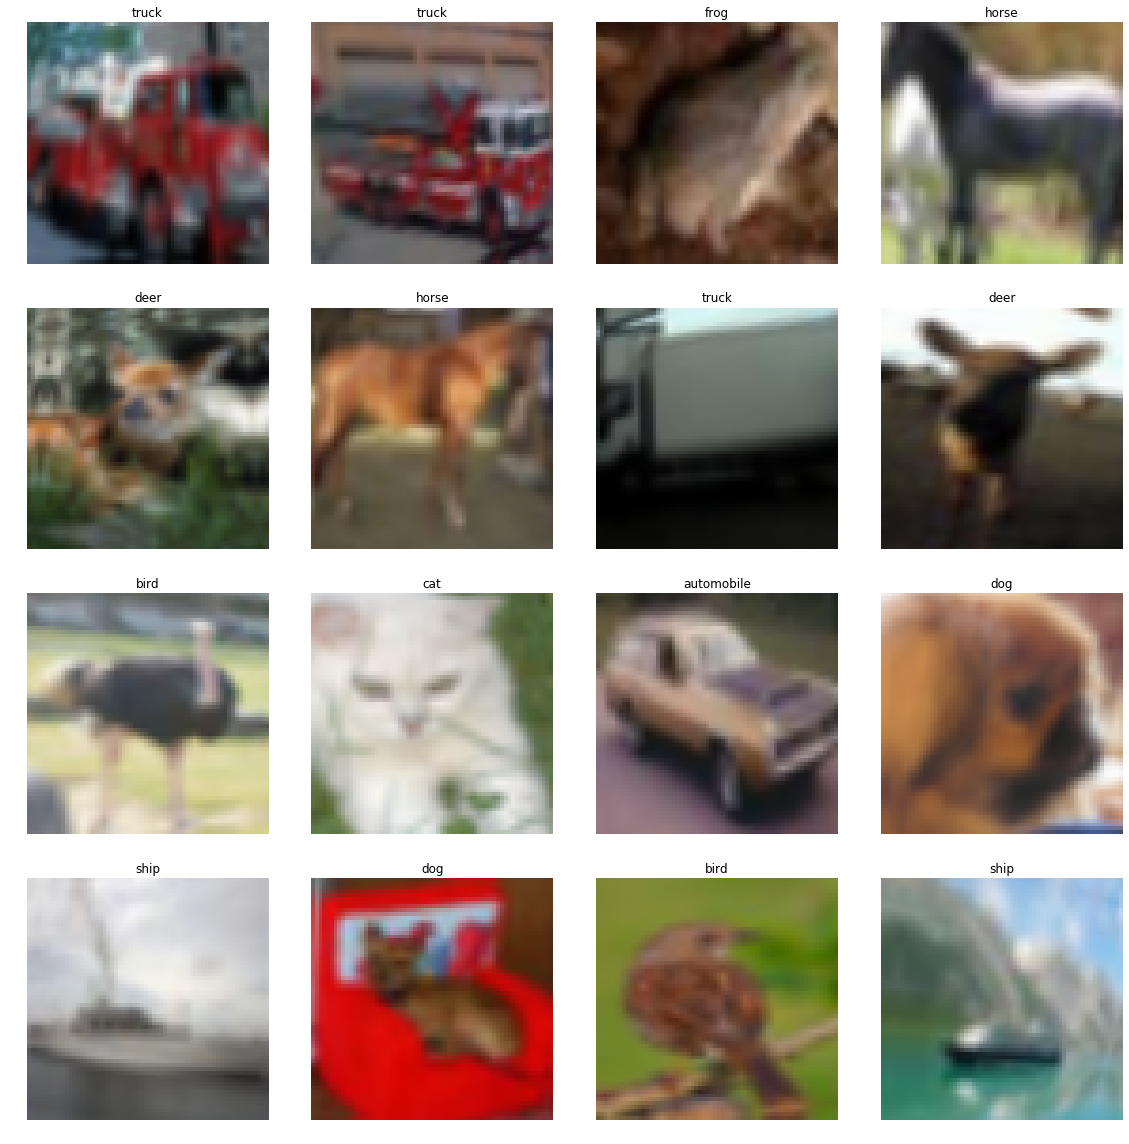

In [4]:
data.show_batch(4)

In [5]:
data.c

10

# Resnet34

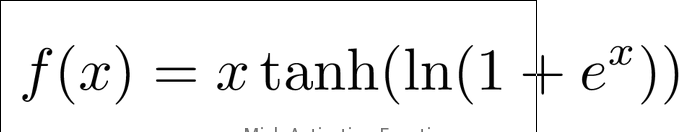

# Mish

In [6]:
model = models.resnet34()

In [53]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

In [71]:
act_fn = Mish()

In [74]:
class Flatten(Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
    
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(stride, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512] +[256]*(len(layers)-4)
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

def xresnet(expansion, n_layers, name, c_out=1000, pretrained=False, **kwargs):
    model = XResNet(expansion, n_layers, c_out=c_out, **kwargs)
    if pretrained: model.load_state_dict(model_zoo.load_url(model_urls[name]))
    return model

me = sys.modules[__name__]
for n,e,l in [
    [ 18 , 1, [2,2,2 ,2] ],
    [ 34 , 1, [3,4,6 ,3] ],
    [ 50 , 4, [3,4,6 ,3] ],
    [ 101, 4, [3,4,23,3] ],
    [ 152, 4, [3,8,36,3] ],
]:
    name = f'xresnet{n}'
    setattr(me, name, partial(xresnet, expansion=e, n_layers=l, name=name))

xresnet34_deepN = partial(xresnet, expansion=1, n_layers=[3, 4,  6, 3,1,1], name='xresnet34_deep')

In [57]:
learn = None
gc.collect()

6655

In [60]:
learn = Learner(
    data, xresnet34_deepN(), metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


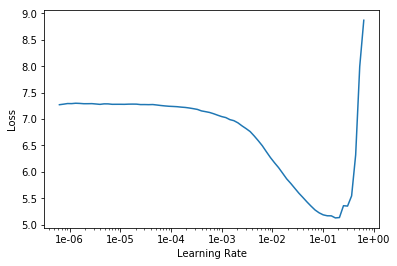

In [61]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.100972,1.226288,0.580250,00:48
1,1.005239,1.054643,0.650750,00:49
2,1.028751,1.040122,0.653083,00:49
3,1.779801,2.470389,0.329250,00:50
4,2.034700,nan,0.227750,00:51
5,1.634319,1.669374,0.385333,00:51
6,1.459301,1.525353,0.461500,00:52
7,1.273278,1.382557,0.522750,00:51
8,1.087648,1.231325,0.572083,00:54
9,0.964546,1.040380,0.635000,00:51


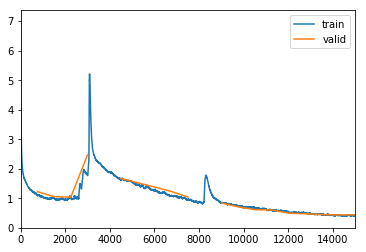

In [62]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-1, wd=1e-3)

# Same thing with relu

In [63]:
learn = None

In [73]:
act_fn = nn.ReLU(inplace=True)

In [75]:
learn = Learner(
    data, xresnet34_deepN(), metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


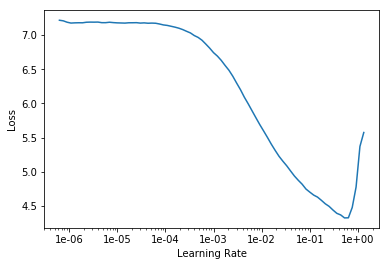

In [76]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.163916,1.329212,0.556417,00:45
1,1.019096,1.152207,0.607083,00:47
2,0.981012,0.892902,0.700500,00:51
3,0.924725,0.899498,0.699417,00:51
4,1.258341,1.356276,0.583500,00:49
5,0.848504,0.695475,0.765167,00:53
6,0.795851,0.908071,0.720750,00:52
7,0.802130,1.056981,0.688750,00:50
8,0.690343,0.630373,0.794333,00:50
9,nan,nan,0.096083,00:49


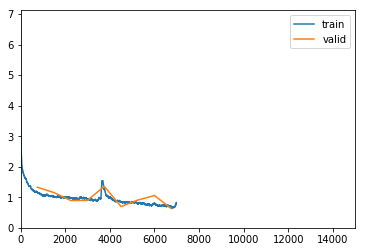

KeyboardInterrupt: 

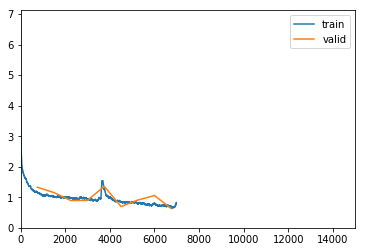

In [77]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-1), wd=1e-3)

# CONCLUSION -> Honestly I dont see much difference 